# Entrenamiento de una red neuronal de una capa oculta  con propagación hacia atrás.

* Una red neuronal es una función universal con  3 tipos de capas: capa de entrada, capas intermedia capa de salida. 

* Un problema es que es impráctico calcular la derivada de una red neuronal de propagación hacia adelante. 
* Una estrategia a seguir es la implementación práctica de la regla de la cadena.

* Por lo que se requiere un algoritmo especial para calcular la derivada basada en la regla de la cadena de cálculo que indica que si se tienen funciones anidadas: $y=g(x), z = f(y)$ o bien $z = f(g(x))$, una manera de resolver esta anidación es aplicando la regla de la cadena. Ejemplo:

$$\frac{d z}{d x} = \frac{dz}{dy} \frac{dy}{dy} $$

* El algoritmo de **Propagación hacia atrás** (Backpropagation, BP), es un algoritmo de entrenamiento supervisado permite calcular la derivada de una red neuronal y por lo tanto actualizar los pesos de todas las capas intermedias.

* Por lo tanto describiremos un código de una red neuronal con fines didácticos.

In [1]:
from math import exp
from random import seed, random
import math
import matplotlib.pyplot as plt

**Inicializando la red**

initialize_network recibe el tamaño del vector de entrada, el número de neuronas en la capa oculta y el numero de neuronas en la capa de salida.

Si inicializamos initialize_network(3, 2, 2), tendremos 2 conjuntos de 3+1 pesos considerando el *bias* para la primera capa que asocia cada entrada de $[x_0,x_1,x_0]$ con cada neurona intermedia. 

In [2]:
def initialize_network(n_inputs, n_hidden, n_outputs):
    """
    n_inputs: tamaño del vector de entrada
    n_hidden: número de neuronas en la capa oculta
    n_outputs: numero de neuronas en la capa de salida.
    """
    network = list()
    
    hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
    network.append(hidden_layer)
    
    output_layer = [{'weights':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
    network.append(output_layer)
    
    return network

**Propagación hacia adelante** (Forwad propagation): salida de la red neuronal dada una entrada $\mathbf{x}$

Es la función principal para realizar la tarea. La entrada se va procesando a través de las capas hasta obtener una salida.

**Activación de la neurona**

Esta compuesta por dos fases

1) El cálculo de una regresión lineal de la forma 

$$y = \mathbf{W}^T \mathbf{X} + b $$

2) La transferencia a la activación de la neurona

$$z = \sigma(y)$$ donde $\sigma(x) = 1/(1+e^{-x}))$

Existen muchas funciones de transferencia como relu, tanh identidad, pero una de las mas utilizadas es la función sigmoide con forma de s o también llamada curva logística. Tiene la forma:


In [3]:
# Calcular W^T X + b
def activate(weights, inputs):
    """
    Regresa el valor de preactivación
    Recibe pesos y entradas
    """
    # W^T*X+b
    #bias: b
    activation = weights[-1]
    
    #calcular b + W*X
    for i in range(len(weights)-1):
        activation += weights[i] * inputs[i]
        
    return activation

In [4]:
def transfer(activation):
    #función de activación
    return 1.0 / (1.0 + exp(-activation))

In [5]:
# Forward propagate input to a network output
def forward_propagate(network, inputs): 
    #recorremos capa por capa de la red neuronal
    for layer in network:
        #preparamos donde guardaremos las entradas de las siguiente capa
        new_inputs = []
        
        for neuron in layer:     
            #y = W^TX + W_0+b
            activation = activate(neuron['weights'], inputs)
             
            #y = sigm(x)
            neuron['output'] = transfer(activation)
            
            #guardar salida en new_inputs, el tamaño de vector de salida es igual al número de neuronas de la capa actual 
            #y debe coincidir con de la entrada
            
            new_inputs.append(neuron['output'])
        
        # la salida de una capa es la entrada de la siguiente de la red
        inputs = new_inputs
        
    return inputs

### Algoritmo de propagación hacia atrás

In [6]:
def transfer_derivative(output):
    '''
    Esta es la derivada de la función sigmoide
    d (1/(1+e^-x))/dx = x(1-x)
    '''
    return output * (1.0 - output)

In [7]:
def backward_propagate_error(network, expected):
    #comenzamos con la capa de salida
    for i in reversed(range(len(network))): 
        # por cada capa de la red asignada a layer
        layer = network[i]
        
        #el tamaño de la capa es equivalente al numero de neuronas
        n_neuronas = len(layer)
        
        #inicializamos error
        errors = list()
        
        # la primera vez calculamos sobre la ultima capa que es a la que tenemos acceso en un inicio
        
        # si la capa i es la última:
        if i == len(network)-1:
            
            # por cada neurona de la capa hacer:
            for j in range(n_neuronas):
                
                #la neurona j de la capa i
                neuron = layer[j]
                
                #el famoso y gorrito que es la estimación de nuestro modelo
                yhat = neuron['output']
                
                #por la codificación, un valor del vector tendra un 1
                y = expected[j]
            
                #esta es la derivada de la función de costo (o error), donde usamos la log verosimilitud y la queremos maximizar
                # Aqui comienza la transferencia
                derivada_error = (yhat-y)/((yhat-1)*yhat)
                errors.append(derivada_error) 
        
        else:
            #aqui son las capas restantes hacia atrás donde propagamos el error
            
            for j in range(n_neuronas):
                error = 0.0
                for neuron in network[i + 1]:
                    
                    #son los pesos de los parametros j de la capa 
                    # multiplicado por la parte de la derivada parcial guardada en delta
                    error += (neuron['weights'][j] * neuron['delta'])
                    
                errors.append(error)
                
        #aqui guardamos todos los delta asociada a cada neurona de cada capa
        for j in range(n_neuronas):
            neuron = layer[j]
            
            #el error magnifica la derivada
            neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])

**Actualizar pesos con el error**

Se recibe la red con los deltas, y un vector de entrada $row$ y la tasa de aprendizaje $l_rate$ asignada por el usuario la cual especifica en porcentaje de actualización que queremos para los pesos.

In [8]:
# Update network weights with error
def update_weights(network, row, l_rate):
    # por cada capa de la red
    for i in range(len(network)):
        #extraer la clasificación real del vector de entrada. 
        inputs = row[:2]
        
        #las salidas ahora son las entradas de la siguiente capa
        if i != 0:
            inputs = [neuron['output'] for neuron in network[i - 1]]
         
        #acceder a las neuronas de la capa i
        for neuron in network[i]:
            #actualizar el gradiente 
            
            #primero los pesos W
            for j in range(len(inputs)):
                
                # por cada neurona y cada una de sus entradas
                #neuronDelta tiene parte de la derivada parcial y se completa con inputs[j] que es la derivada 
                #parcial de la funcion \partial W^TX + B / \partial w_j
                neuron['weights'][j] += l_rate * neuron['delta'] * inputs[j]
            
            #despues actualización del sesgo (bias)
            #es la derivada parcial de la funcion \partial W^TX + B / \partial b_j
            neuron['weights'][-1] += l_rate * neuron['delta']

**Entrenar la red con Gradiente Descendiente estocástico**

* Es una variante del algoritmo de descenso de gradiente.
* Es una de las variantes mas utilizadas, y de este se desprenden otras subvariantes.
* La principal característica es que el gradiente se calcula con un subconjunto de datos del conjunto de entrenamiento cada iteración. 
![alt text for screen readers](https://i.ibb.co/0Y6nTSn/SGD-DP-Good-Fellow.png "Text to show on mouseover")

In [84]:
from IPython.display import clear_output
def train_network(network, train, l_rate, n_epoch, n_outputs):
    global l_errors
    l_errors=[]
    for epoch in range(n_epoch):
        sum_error = 0

        #por cada vector en el conjunto de entrenamiento.
        for row in train:
            # se calcular la salida de un elemento del vector
            zi_e = forward_propagate(network, row)[0]
            
            #la posición row[-1] \in {0,1} tendrá un 1 como inicialización.
            #row es unidiemnsional y contiene 0 o 1 que representa la clase y la posición en la c
            # si la etiqueta del data set en y tiene un cero, este será la posicion donde asignaremos un 1
            zi = int(row[-1])
        
            #aquí el error reportado es la suma log verosimilitud , queremos que sea el máximo
            sum_error += zi*math.log(zi_e)+(1-zi)*math.log(1-zi_e)
        
            #print(expected)
            #propagamos hacia atrás 
            #el error generado por la diferencia de el valor esperado y el valor generado por la red
            # se reajusta la red para predecir mejor el valor esperado
            
            #Aquí esta el gradiente estocástico con un minibatch de tamaño 1.
            backward_propagate_error(network, [zi])
            update_weights(network, row, l_rate)
        l_errors.append(sum_error)
        clear_output(wait=True)
        print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))

In [158]:
f = lambda x: forward_propagate(network, x)

def errors(dataset,f):
    e=0
    for x in dataset[:]:
        yhat = f(x)
        #x[-1] es la ultima columna del vector y \in R^2 [0,1] = 
        e+= (x[-1]- 1*((yhat[-1])>0.5))**2
    return e

### Ejemplo XOR

In [255]:
### Construyendo el dataset que queremos ajustar, el famoso problema del xor
dataset = [
    [0,1,1],
    [1,0,1],
    [0,0,0],
    [1,1,0]]
dataset = np.asarray(dataset)
dataset.shape

(4, 3)

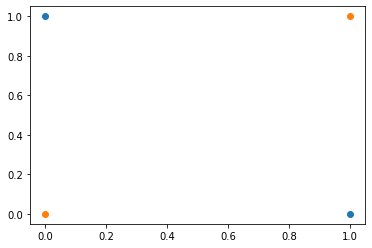

In [256]:
# Graficamos el xor 
import numpy as np
dataset = np.array(dataset)
plt.scatter(dataset[:2,0],dataset[:2,1])
plt.scatter(dataset[2:,0],dataset[2:,1])

In [257]:
seed(2)

n_inputs = len(dataset[0]) - 1
print("inputs: ", n_inputs)

#total possible number of output values
n_outputs = len(set([ int(row[-1]) for row in dataset]))
print("possible number of output values: ", n_outputs)

inputs:  2
possible number of output values:  2


In [258]:
network = initialize_network(2,2,1)
network

[[{'weights': [0.9560342718892494, 0.9478274870593494, 0.05655136772680869]},
  {'weights': [0.08487199515892163, 0.8354988781294496, 0.7359699890685233]}],
 [{'weights': [0.6697304014402209, 0.3081364575891442, 0.6059441656784624]}]]

In [259]:
for x in dataset:    
    y = forward_propagate(network, x[:2])
    print("entrada",[x[:2]] , "valor real:",x[-1],"estimación ",1*((y[-1])>=0.5), " reality float:",1*(y[-1]))

entrada [array([0, 1])] valor real: 1 estimación  1  reality float: 0.7943367116823498
entrada [array([1, 0])] valor real: 1 estimación  1  reality float: 0.7877111014072092
entrada [array([0, 0])] valor real: 0 estimación  1  reality float: 0.7610801895682618
entrada [array([1, 1])] valor real: 0 estimación  1  reality float: 0.8102708873493658


In [260]:
print ("Error antes de entrenar con backpropagation: ", errors(dataset,f))

Error antes de entrenar con backpropagation:  2


In [261]:
train_network(network, dataset, 0.3, 2000, n_outputs)

>epoch=1999, lrate=0.300, error=-0.019


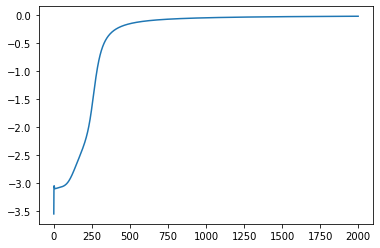

In [265]:
plt.plot(l_errors)

In [262]:
network

[[{'weights': [7.226833404300632, 7.231459093320985, -3.2868480291171682],
   'output': 0.9999859299089527,
   'delta': -7.52385269556139e-07},
  {'weights': [5.431567859159015, 5.427986924860976, -8.303794310786003],
   'output': 0.92772972718295,
   'delta': 0.0038143393156944653}],
 [{'weights': [11.91401839185154, -12.677651297666692, -5.558143034175064],
   'output': 0.0044878894046708265,
   'delta': -0.0044878894046708265}]]

In [263]:
for x in dataset:    
    y = forward_propagate(network, x[:2])
    print("entrada",[x[:2]] , " valor real:",x[-1]," estimación:",1*((y[-1])>=0.5), " reality float:",1*(y[-1]))

entrada [array([0, 1])]  valor real: 1  estimación: 1  reality float: 0.9957352739693067
entrada [array([1, 0])]  valor real: 1  estimación: 1  reality float: 0.9957211268281752
entrada [array([0, 0])]  valor real: 0  estimación: 0  reality float: 0.005869630386719038
entrada [array([1, 1])]  valor real: 0  estimación: 0  reality float: 0.0044577653564406


In [264]:
print ("Error despues de entrenar con backpropagation: ", errors(dataset,f))

Error despues de entrenar con backpropagation:  0


# Con el conjunto de datos de Iris

    1 Entrenar una red neuronal de clasificación binaria que identifique flores iris-setosa / no iris-setosa, apoyándose del código proporcionado en clase. Usar el conjunto de datos de Iris (https://archive.ics.uci.edu/ml/datasets/iris) (Leer bien la descripción). El modelo debe asociar los atributos con la etiqueta. (35/70).
    2 Hacer validación cruzada de dos particiones, para esto: (35/70)
        * “Revolver los vectores” de manera aleatoria (utilizar numpy.random.shuffle ).
        * Partir el conjunto de datos en 2 conjuntos mutuamente excluyentes.
        * La primera vez se hará una primera partición: el primer conjunto será usado para entrenamiento y el segundo como prueba. Se calculará el error e_1e 
        * Viceversa para la segunda vez. Se calculará el error e_2e 
        * Reportar el error generalizado obtenido con la validación cruzada que sería

Descargados de https://www.kaggle.com/datasets/uciml/iris?resource=download

## Lectura de datos y preparación de los datos

In [597]:
import pandas as pd
import matplotlib.pyplot as plt

In [598]:
df = pd.read_csv("DATOS/Iris.csv") 

In [599]:
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [600]:
#Borra la columna de Id, que esta de mas
df = df.drop('Id',axis=1)
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [601]:
df.groupby('Species').size()

Species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
dtype: int64

In [602]:
#Iris-setosa = 1
#Otros (No Iris-setosa) = 0
df = df.replace({"Iris-setosa": 1, "Iris-versicolor": 0, "Iris-virginica": 0})

In [603]:
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1


In [604]:
df.groupby('Species').size()

Species
0    100
1     50
dtype: int64

In [605]:
#Convertir el dataframe a un array numpy
dataset = df.to_numpy()

In [606]:
dataset.shape

(150, 5)

## Ejercicio con todos los datos

In [471]:
seed(2)
n_inputs = len(dataset[0]) - 1
print("inputs: ", n_inputs)

#total possible number of output values
n_outputs = len(set([ int(row[-1]) for row in dataset]))
print("possible number of output values: ", n_outputs)

inputs:  4
possible number of output values:  2


In [476]:
#Parametros iniciales
network = initialize_network(n_inputs,2,1)
network

[[{'weights': [0.5257527691460283,
    0.5605103610264989,
    0.23612340711506208,
    0.023858079140782196,
    0.32514292876116]},
  {'weights': [0.13669739298646666,
    0.5102238458372012,
    0.998683568192552,
    0.6744796973458701,
    0.18184349682314438]}],
 [{'weights': [0.8935715365829885, 0.7967599214216395, 0.7344016918939777]}]]

In [477]:
for x in dataset:    
    y = forward_propagate(network, x[:n_inputs])
    print("entrada",[x[:n_inputs]] , "valor real:",x[-1],"estimación ",1*((y[-1])>=0.5), " reality float:",1*(y[-1]))

entrada [array([5.1, 3.5, 1.4, 0.2])] valor real: 1.0 estimación  1  reality float: 0.917474269845914
entrada [array([4.9, 3. , 1.4, 0.2])] valor real: 1.0 estimación  1  reality float: 0.9170310773754365
entrada [array([4.7, 3.2, 1.3, 0.2])] valor real: 1.0 estimación  1  reality float: 0.9169932538787543
entrada [array([4.6, 3.1, 1.5, 0.2])] valor real: 1.0 estimación  1  reality float: 0.9171124067827602
entrada [array([5. , 3.6, 1.4, 0.2])] valor real: 1.0 estimación  1  reality float: 0.9175076993788833
entrada [array([5.4, 3.9, 1.7, 0.4])] valor real: 1.0 estimación  1  reality float: 0.9180322624195498
entrada [array([4.6, 3.4, 1.4, 0.3])] valor real: 1.0 estimación  1  reality float: 0.9173034118275321
entrada [array([5. , 3.4, 1.5, 0.2])] valor real: 1.0 estimación  1  reality float: 0.9174751501360575
entrada [array([4.4, 2.9, 1.4, 0.2])] valor real: 1.0 estimación  1  reality float: 0.9167000170065824
entrada [array([4.9, 3.1, 1.5, 0.1])] valor real: 1.0 estimación  1  reali

entrada [array([6.2, 3.4, 5.4, 2.3])] valor real: 0.0 estimación  1  reality float: 0.91861758780091
entrada [array([5.9, 3. , 5.1, 1.8])] valor real: 0.0 estimación  1  reality float: 0.918569453594004


In [478]:
print ("Error antes de entrenar: ", errors(dataset,f))

Error antes de entrenar:  100.0


In [479]:
#Entrenando la red
train_network(network, dataset, 0.03, 1000, n_outputs)

>epoch=999, lrate=0.030, error=-0.213


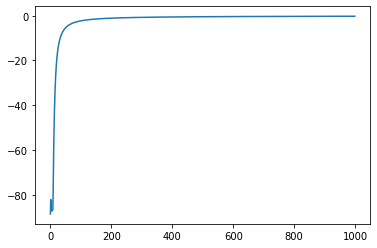

In [480]:
plt.plot(l_errors)

In [481]:
network

[[{'weights': [0.7990131101275161,
    0.7552643872828017,
    0.23612340711506208,
    0.023858079140782196,
    0.3871551334649809],
   'output': 0.9998185411300539,
   'delta': -3.7392330278904323e-07},
  {'weights': [1.685417583126067,
    -3.735267885376774,
    0.998683568192552,
    0.6744796973458701,
    -1.5620225869739022],
   'output': 0.9702043947131658,
   'delta': 0.0002538822323987627}],
 [{'weights': [3.4408997096357954, -14.662516512531749, 3.3656186202833642],
   'output': 0.0005989752268850784,
   'delta': -0.0005989752268850784}]]

In [404]:
for x in dataset:    
    y = forward_propagate(network, x[:4])
    print("entrada",[x[:4]] , "| valor real:",x[-1],"| estimación:",1*((y[-1])>=0.5), "| reality float:",1*(y[-1]))

entrada [array([5.1, 3.5, 1.4, 0.2])] | valor real: 1.0 | estimación: 1 | reality float: 0.9988533967091496
entrada [array([4.9, 3. , 1.4, 0.2])] | valor real: 1.0 | estimación: 1 | reality float: 0.9967595975127677
entrada [array([4.7, 3.2, 1.3, 0.2])] | valor real: 1.0 | estimación: 1 | reality float: 0.9988684085847274
entrada [array([4.6, 3.1, 1.5, 0.2])] | valor real: 1.0 | estimación: 1 | reality float: 0.998800176055482
entrada [array([5. , 3.6, 1.4, 0.2])] | valor real: 1.0 | estimación: 1 | reality float: 0.9990423963264655
entrada [array([5.4, 3.9, 1.7, 0.4])] | valor real: 1.0 | estimación: 1 | reality float: 0.9990010911887545
entrada [array([4.6, 3.4, 1.4, 0.3])] | valor real: 1.0 | estimación: 1 | reality float: 0.9990907565624272
entrada [array([5. , 3.4, 1.5, 0.2])] | valor real: 1.0 | estimación: 1 | reality float: 0.9987963617966913
entrada [array([4.4, 2.9, 1.4, 0.2])] | valor real: 1.0 | estimación: 1 | reality float: 0.9987098800673855
entrada [array([4.9, 3.1, 1.5

entrada [array([6.7, 3. , 5.2, 2.3])] | valor real: 0.0 | estimación: 0 | reality float: 0.0003145540838341261
entrada [array([6.3, 2.5, 5. , 1.9])] | valor real: 0.0 | estimación: 0 | reality float: 0.00030866815733952455
entrada [array([6.5, 3. , 5.2, 2. ])] | valor real: 0.0 | estimación: 0 | reality float: 0.0003332333051867056
entrada [array([6.2, 3.4, 5.4, 2.3])] | valor real: 0.0 | estimación: 0 | reality float: 0.0008421569612887584
entrada [array([5.9, 3. , 5.1, 1.8])] | valor real: 0.0 | estimación: 0 | reality float: 0.0006424775124389894


In [482]:
print ("Error despues de entrenar: ", errors(dataset,f))

Error despues de entrenar:  0.0


## Aplicando validacion cruzada

In [607]:
#Revolver los vectores” de manera aleatoria
np.random.shuffle(dataset)
dataset.shape

(150, 5)

In [608]:
dataset

array([[6.7, 3.1, 4.4, 1.4, 0. ],
       [5.5, 2.3, 4. , 1.3, 0. ],
       [6.2, 3.4, 5.4, 2.3, 0. ],
       [6.4, 3.2, 5.3, 2.3, 0. ],
       [4.9, 2.4, 3.3, 1. , 0. ],
       [6. , 3.4, 4.5, 1.6, 0. ],
       [4.9, 3. , 1.4, 0.2, 1. ],
       [4.5, 2.3, 1.3, 0.3, 1. ],
       [5.2, 3.5, 1.5, 0.2, 1. ],
       [5.2, 3.4, 1.4, 0.2, 1. ],
       [5.7, 2.8, 4.1, 1.3, 0. ],
       [6.9, 3.2, 5.7, 2.3, 0. ],
       [6. , 2.9, 4.5, 1.5, 0. ],
       [6.4, 3.2, 4.5, 1.5, 0. ],
       [7.9, 3.8, 6.4, 2. , 0. ],
       [5. , 3.5, 1.3, 0.3, 1. ],
       [5. , 3. , 1.6, 0.2, 1. ],
       [5.6, 2.8, 4.9, 2. , 0. ],
       [5.8, 2.7, 4.1, 1. , 0. ],
       [4.6, 3.2, 1.4, 0.2, 1. ],
       [6.3, 2.9, 5.6, 1.8, 0. ],
       [6.1, 2.8, 4.7, 1.2, 0. ],
       [6.1, 3. , 4.6, 1.4, 0. ],
       [4.6, 3.1, 1.5, 0.2, 1. ],
       [5. , 3.3, 1.4, 0.2, 1. ],
       [5. , 3.4, 1.5, 0.2, 1. ],
       [7.7, 3.8, 6.7, 2.2, 0. ],
       [5.5, 3.5, 1.3, 0.2, 1. ],
       [6.5, 3. , 5.8, 2.2, 0. ],
       [5.5, 2

In [609]:
#Partiendo el conjunto de datos en 2 conjuntos mutuamente excluyentes. (p1 y p2)
#Particion 1 = p1
#Particion 2 = p2
p1 = dataset[:75]
p2 = dataset[75:]
p1.shape,p2.shape

((75, 5), (75, 5))

In [611]:
#Partiendo ambos conjuntos en entrenamiento (train) y prueba (test).
p1_train = p1[:38]
p1_test = p1[38:]
print(p1_train.shape, p1_test.shape)

p2_train = p2[:38]
p2_test = p2[38:]
print(p2_train.shape, p2_test.shape)

(38, 5) (37, 5)
(38, 5) (37, 5)


In [612]:
#Determinando el numero de entradas y el número de valores posibles de la salida
seed(2)
n_inputs = len(p1_train[0]) - 1
print("inputs: ", n_inputs)

#total possible number of output values
n_outputs = len(set([ int(row[-1]) for row in p1_train]))
print("possible number of output values: ", n_outputs)

inputs:  4
possible number of output values:  2


In [613]:
E_gen = []

### Para la Particion 1:

In [614]:
network = initialize_network(n_inputs,2,1)
network

[[{'weights': [0.9560342718892494,
    0.9478274870593494,
    0.05655136772680869,
    0.08487199515892163,
    0.8354988781294496]},
  {'weights': [0.7359699890685233,
    0.6697304014402209,
    0.3081364575891442,
    0.6059441656784624,
    0.6068017336408379]}],
 [{'weights': [0.5812040171120031, 0.15838287025480557, 0.43066964029126864]}]]

In [615]:
print ("Errores antes de entrenar: ", errors(p1_train,f))

Errores antes de entrenar:  22.0


In [616]:
train_network(network, p1_train, 0.03, 1000, n_outputs)

>epoch=999, lrate=0.030, error=-0.600


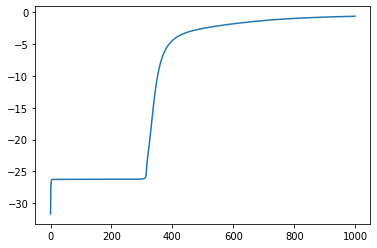

In [617]:
plt.plot(l_errors)

In [618]:
network

[[{'weights': [1.0007743886560159,
    0.9740281251153461,
    0.05655136772680869,
    0.08487199515892163,
    0.8458403152616834],
   'output': 0.9998847979570791,
   'delta': 1.6162036850453696e-06},
  {'weights': [2.4328550806046265,
    -3.4922444484025137,
    0.3081364575891442,
    0.6059441656784624,
    -4.415400001457807],
   'output': 0.01805660109536394,
   'delta': -0.0010273738948522223}],
 [{'weights': [2.8225741181916577, -11.655809232345886, 2.6876187319570293],
   'output': 0.9950287736670107,
   'delta': 0.004971226332989298}]]

In [619]:
for x in p1_test:    
    y = forward_propagate(network, x[:n_inputs])
    print("valor real:",x[-1]," estimación:",1*((y[-1])>=0.5), " reality float:",1*(y[-1]))

valor real: 0.0  estimación: 0  reality float: 0.002426357278076762
valor real: 0.0  estimación: 0  reality float: 0.13511149397444247
valor real: 0.0  estimación: 0  reality float: 0.004547074287908653
valor real: 0.0  estimación: 0  reality float: 0.0037318317956374666
valor real: 0.0  estimación: 0  reality float: 0.010173828819256523
valor real: 0.0  estimación: 0  reality float: 0.005380639869182647
valor real: 1.0  estimación: 1  reality float: 0.9948794187775957
valor real: 0.0  estimación: 0  reality float: 0.010994846465781555
valor real: 0.0  estimación: 0  reality float: 0.047295412691814705
valor real: 1.0  estimación: 1  reality float: 0.9956916408321281
valor real: 0.0  estimación: 0  reality float: 0.0024838104215815907
valor real: 0.0  estimación: 0  reality float: 0.006435103342609753
valor real: 1.0  estimación: 1  reality float: 0.9945417628822881
valor real: 0.0  estimación: 0  reality float: 0.003241053234907248
valor real: 0.0  estimación: 0  reality float: 0.0022

In [620]:
print ("Error despues de entrenar: ", errors(p1_test,f))

Error despues de entrenar:  0.0


In [621]:
E_gen.append(errors(p1_test,f))

### Para la Particion 2:

In [622]:
network = initialize_network(n_inputs,2,1)
network

[[{'weights': [0.39353182020537136,
    0.7230120812374659,
    0.9948195629497427,
    0.9493954730932436,
    0.5441770474293208]},
  {'weights': [0.4448541887258536,
    0.2682407416493281,
    0.03592432939285761,
    0.027444857090819008,
    0.4648938620973121]}],
 [{'weights': [0.3184651278536774, 0.3800149219007116, 0.8917894578282874]}]]

In [623]:
print ("Errores antes de entrenar: ", errors(p2_train,f))

Errores antes de entrenar:  26.0


In [624]:
train_network(network, p2_train, 0.03, 1000, n_outputs)

>epoch=999, lrate=0.030, error=-0.188


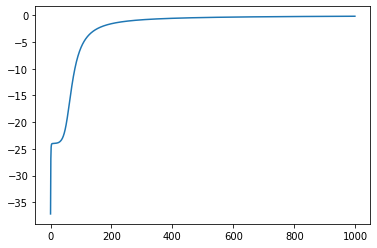

In [625]:
plt.plot(l_errors)

In [585]:
network

[[{'weights': [0.8940618136311224,
    0.7266792985574354,
    0.4727795120983127,
    0.22552757034788762,
    0.6675137936352853],
   'output': 0.999669066469455,
   'delta': 6.963352723036094e-06},
  {'weights': [2.4167385941406065,
    -4.756007171879585,
    0.44782186141915115,
    0.8747630413479673,
    -0.8383198777670865],
   'output': 0.04367412648027497,
   'delta': -0.0037507683970195585}],
 [{'weights': [2.709846700313035, -11.560476869776425, 2.64634334210391],
   'output': 0.992231914744885,
   'delta': 0.007768085255114965}]]

In [626]:
for x in p2_test:    
    y = forward_propagate(network, x[:n_inputs])
    print("valor real:",x[-1]," estimación:",1*((y[-1])>=0.5), " reality float:",1*(y[-1]))

valor real: 0.0  estimación: 0  reality float: 0.00274189316621792
valor real: 1.0  estimación: 1  reality float: 0.9839739737819788
valor real: 0.0  estimación: 0  reality float: 0.0020382218433972464
valor real: 0.0  estimación: 0  reality float: 0.0021283816268965416
valor real: 0.0  estimación: 0  reality float: 0.0029034785119599277
valor real: 0.0  estimación: 0  reality float: 0.0020638418691179047
valor real: 0.0  estimación: 0  reality float: 0.019305433876034155
valor real: 1.0  estimación: 1  reality float: 0.9837456979997063
valor real: 1.0  estimación: 1  reality float: 0.9938556934517769
valor real: 0.0  estimación: 0  reality float: 0.002184279818444503
valor real: 1.0  estimación: 1  reality float: 0.9948311386014058
valor real: 0.0  estimación: 0  reality float: 0.0050264121776434495
valor real: 0.0  estimación: 0  reality float: 0.0021040614227103463
valor real: 0.0  estimación: 0  reality float: 0.002043972318765234
valor real: 0.0  estimación: 0  reality float: 0.00

In [627]:
print ("Error despues de entrenar: ", errors(p2_test,f))

Error despues de entrenar:  0.0


In [628]:
E_gen.append(errors(p1_test,f))

### Error general

In [631]:
E_gen

[0.0, 0.0]

In [632]:
print("Error generalizado obtenido con la validación cruzada: ",sum(E_gen)/len(E_gen))

Error generalizado obtenido con la validación cruzada:  0.0
